In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy import pi, sin, cos, arccos
from astropy.coordinates import get_sun
from astropy.time import Time
import astropy

from ArielUtils.Constants import *
from ArielUtils.Functions import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time =  Time(59945, format='mjd')
time.jd - 2450000

9945.5

In [3]:
df = pd.read_csv("ASM_Ariel_sort.csv")

In [4]:
targets = df[['Star Name', 'Star RA', 'Star Dec', 'Planet Period [days]', 'Transit Duration [s]', 'Transit Mid Time [JD - 2450000]']]
targets['Transit Mid Time [JD - 2450000]'] = targets['Transit Mid Time [JD - 2450000]'].apply(lambda x: Time(x+2450000, format='jd').mjd)
targets['Transit Mid Time [JD - 2450000]'] = targets['Transit Mid Time [JD - 2450000]'] - targets['Transit Duration [s]']/60/60/24
targets.rename(columns={'Transit Mid Time [JD - 2450000]': 'T_ref'}, inplace=True)

# Because this data does not include a refence date, we will add some arbitrary one ourselves
##--- IF DATA COMES WITH REFERENCE TIME, DO NOT INCLUDE THIS NEXT PART! ---##
# targets = targets.assign(T_ref=T0)

targets.head(3)

,Star Name,Star RA,Star Dec,Planet Period [days],Transit Duration [s],T_ref
0,HIP 65 A b,0.185606,-54.830823,0.980973,6086.249957,58325.533737
1,HD 189733 b,300.182122,22.709776,2.218576,6544.787710,53954.949801
2,WASP-33 b,36.712738,37.550444,1.219870,9739.030430,54162.610950


In [16]:
initial_MJD_time = 59945 # January 1st 2023 in modified julian date format (MJD)

current_ra = 0
current_dec = 0

previous_long_calib = 0
previous_short_calib = 0
time_elapsed = 0.
observed_events = 0
targets_observed = []
list_targets = targets.copy(deep=True)

# converting duration from years to minutes then cycling through 1 year of operation
while time_elapsed < MISSION_DURATION:
    current_time = Time(initial_MJD_time + time_elapsed/(60*24), 
                        format='mjd')
    
    # finding currently visible targets
    currently_visible = find_visible_targets(targets = list_targets, 
                                             time = current_time
                                             )
    
    try:
        # sorting the visible targets in order of fitness
        fitest_targets = sort_by_fitness(currently_visible, current_time, current_ra, current_dec)

        # THIS IS WHERE ERRORS OCCUR --> OCCASIONALLY THE SORT_BY_FITNESS RETURNS AN EMPTY DATAFRAME, NOT SURE EXACTLY WHY THAT IS :(
        fitest_target = fitest_targets.iloc[[0]]

        list_targets = list_targets.drop(fitest_target.index) # drops target that has been observed
        
        targets_observed.append(fitest_targets['Star Name'].iloc[0]) # adds target to the list of observed targets
        
        target_dec, target_ra = fitest_targets['Star Dec'].iloc[0], fitest_targets['Star RA'].iloc[0]
        slewtime = find_slewtime_minutes(dec1 = np.radians(current_dec), 
                                        ra1 = np.radians(current_ra), 
                                        dec2 = np.radians(target_dec), 
                                        ra2 = np.radians(target_ra)
                                        )
        
        # updates current position
        current_dec, current_ra = target_dec, target_ra 
        
        # increases time by slewtime and average event duration (+ baseline)
        time_elapsed += slewtime + SETTLE_TIME
        time_elapsed += fitest_targets['Transit Duration [s]'].iloc[0]/60 *(1 + 2*BASELINE_RATIO)
        
        # increase number of observed events
        observed_events += 1
        # print(observed_events, ' Events observed')
        
    except:
        time_elapsed += 20
        # print("waiting 20 minutes...")
        
    finally:
        # calibration checks
        if check_calibration(time_elapsed, LONG_CALIBRATION_FREQUENCY, LONG_CALIBRATION_ERR, previous_long_calib):
            time_elapsed += LONG_CALIBRATION_DURATION
            previous_long_calib = previous_short_calib = time_elapsed
            # print("Long calibration")
            
        elif check_calibration(time_elapsed, SHORT_CALIBRATION_FREQUENCY, SHORT_CALIBRATION_ERR, previous_short_calib):
            time_elapsed += SHORT_CALIBRATION_DURATION
            previous_short_calib = time_elapsed
            # print('Short calibration')

In [7]:
observed_events

604

In [8]:
fitest_targets = sort_by_fitness(targets)
fitest_targets.head(720)

,Star Name,Star RA,Star Dec,Planet Period [days],Transit Duration [s],T_ref,Fitness,Wait Time
497,GJ 3473 b,120.593607,3.337163,1.198003,3433.186575,58491.664344,561.301235,2.073439
118,KELT-15 b,117.414976,-52.120447,3.329440,14830.879550,58563.382266,421.490008,10.374869
252,WASP-47 b,331.203092,-12.019067,4.159129,12886.793680,57007.282979,376.935227,14.889058
473,K2-28 b,335.623314,-7.956353,2.260455,3941.527603,56977.444500,335.620833,8.698609
98,WASP-8 b,359.900874,-35.031335,8.158720,11486.343090,54678.700996,222.944494,51.697228
...,...,...,...,...,...,...,...,...
371,HATS-48 A b,288.672005,-59.579350,3.131667,8504.861169,57099.951784,0.000000,-22.257564
130,Qatar-9 b,160.748095,60.964119,1.540731,6769.651828,58227.178078,0.000000,-2.974141
73,WASP-135 b,267.284885,29.879043,1.401379,5750.179053,55230.423647,0.000000,-8.212152
584,K2-129 b,289.148549,-25.646323,8.239493,5987.079960,57334.439705,0.000000,-6.369165


In [9]:
# fit = sort_by_fitness(currently_visible, current_time, current_ra, current_dec)
currently_visible

""


In [10]:
observed_events

604

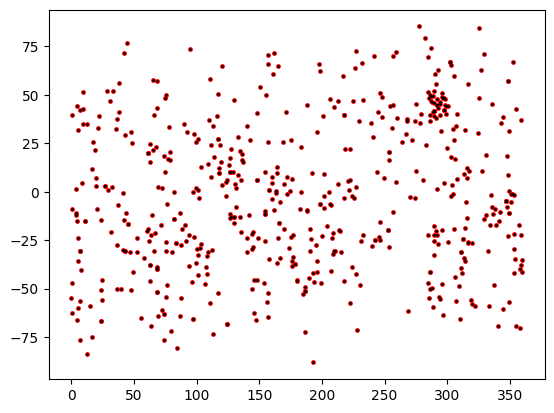

In [11]:
targets_observed_df = []
for target in targets.iloc:
    if target['Star Name'] in targets_observed:
        targets_observed_df.append(target)
targets_observed_df = pd.DataFrame(targets_observed_df)

plt.scatter(targets['Star RA'], targets['Star Dec'], s=6, color='red')
plt.scatter(targets_observed_df['Star RA'], targets_observed_df['Star Dec'], s=1, color='black')

plt.show()

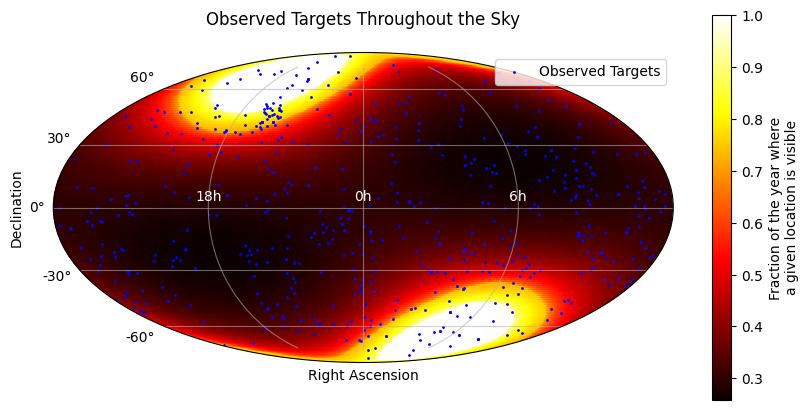

In [12]:
from ArielUtils.VisibilityPlot import plot_sky_view

plot_sky_view(targets_observed_df, title="Observed Targets Throughout the Sky", label='Observed Targets', plot_ecliptic=False, long_pts=360, projection='mollweide')

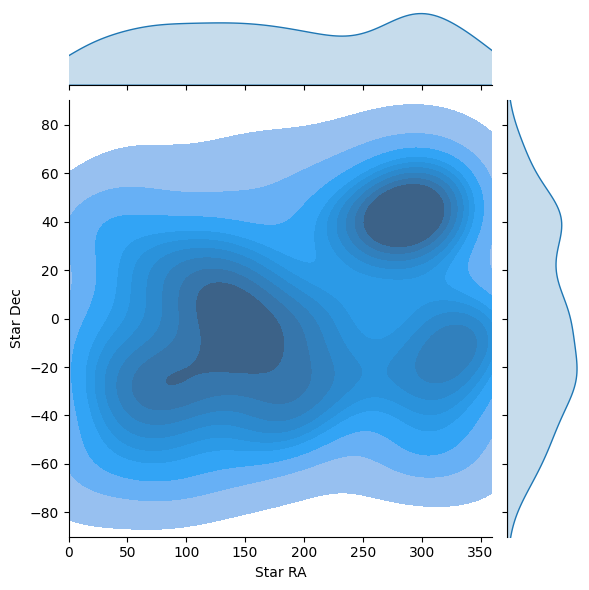

In [13]:
# Quick plot to see where all targets are in the sky

# plt.scatter(targets['Star RA'], targets['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=targets, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()

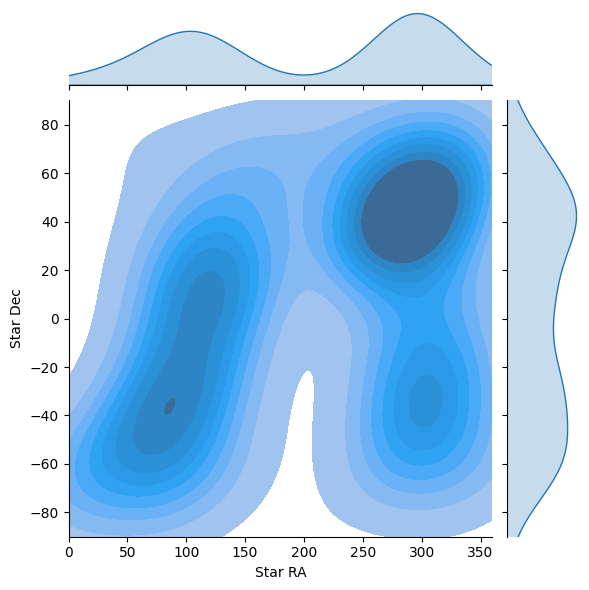

In [14]:
# Quick plot to see where the visible targets are at an aforementionned time.

target_list = find_visible_targets(targets)
target_list

# plt.scatter(target_list['Star RA'], target_list['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=target_list, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()